# Word2Vec

https://github.com/SLCFLAB/FinTech2020/blob/master/code/ch16.ipynb

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    !pip install -q -U tensorflow-addons
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

TensorFlow 2.x selected.
No GPU was detected. LSTMs and CNNs can be very slow without a GPU.
Go to Runtime > Change runtime and select a GPU hardware accelerator.


##CBOW 구조

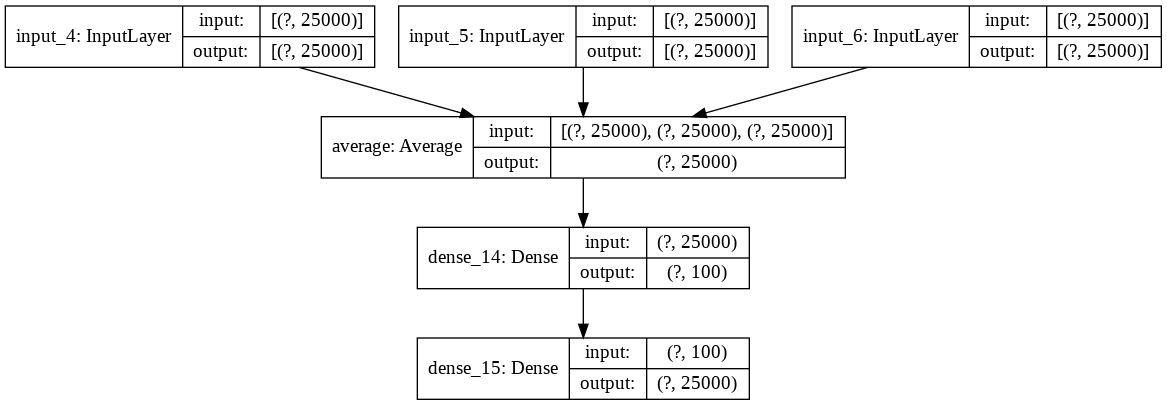

In [37]:
embedding_dim=100
vocab_size = 25000
n_words = 5000

# 오리지널 CBOW 구조 --> 메모리를 많이 잡아먹고, 계산이 비효율적이다
## input으로 25000차원짜리 one-hot 벡터사용(메모리, W 곱셈 계산의 비효율)
## output activation에서 softmax 통과 --> 계산상의 비효율

input1 = keras.layers.Input((vocab_size,))
input2 = keras.layers.Input((vocab_size,))
input3 = keras.layers.Input((vocab_size,))
avr = keras.layers.Average()([input1, input2, input3])
hidden = keras.layers.Dense(embedding_dim)(avr)
output = keras.layers.Dense(vocab_size, activation='softmax')(hidden)

model = keras.models.Model(inputs=[input1, input2, input3], outputs=output)

keras.utils.plot_model(model, show_shapes=True)

In [0]:
model.compile(optimizer='adam', loss='categorical_crossentropy')

In [0]:
w = model.get_weights()

In [30]:
w[0].shape # W_in, 모든 인풋에 대해 공유(동일) # w[1]은 상수 텀 

(25000, 100)

In [31]:
w[2].shape # W_out # w[3]은 상수텀

(100, 25000)

### skip-gram 구조

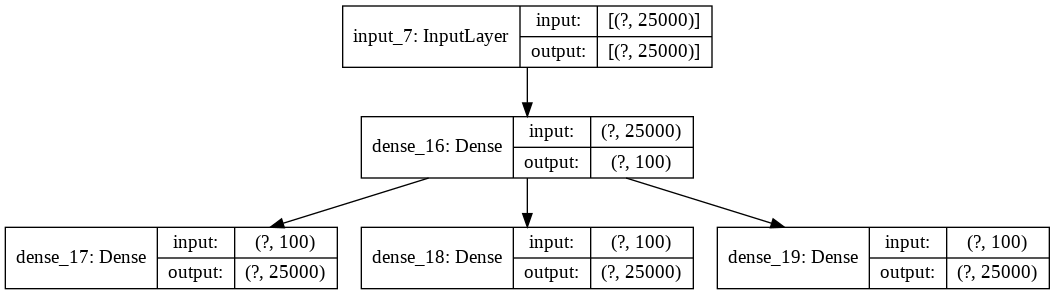

In [38]:
embedding_dim=100
vocab_size = 25000

# 오리지널 CBOW 구조 --> 메모리를 많이 잡아먹고, 계산이 비효율적이다
## input으로 25000차원짜리 one-hot 벡터사용(메모리, W 곱셈 계산의 비효율)
## output activation에서 softmax 통과 --> 계산상의 비효율

input_ = keras.layers.Input((vocab_size,))
hidden = keras.layers.Dense(embedding_dim)(input_)
output1 = keras.layers.Dense(vocab_size, activation='softmax')(hidden)
output2 = keras.layers.Dense(vocab_size, activation='softmax')(hidden)
output3 = keras.layers.Dense(vocab_size, activation='softmax')(hidden)

model = keras.models.Model(inputs=input_, outputs=[output1, output2, output3])

keras.utils.plot_model(model, show_shapes=True)

In [0]:
model.compile(optimizer='adam', loss='categorical_crossentropy')

In [0]:
w = model.get_weights()

In [41]:
w[0].shape # W_in # w[1]은 상수 텀 

(25000, 100)

In [42]:
w[2].shape # W_out, 모든 아웃풋에 대해 공유(동일) # w[3]은 상수텀

(100, 25000)

## 개선

### embedding layer를 쓴다

In [0]:
input_ = keras.layers.Input((1,))
embedding = keras.layers.Embedding(vocab_size, embedding_dim)(input_)

# 25000차원 짜리 one-hot vector가 아니라 정수로 된 index를 input 으로 받자
# one-hot vector * W는 결국 연산을 하더라도 W의 한 행만 뽑아냄 = W의 행들 중 index에 해당하는 행만 뽑는 것과 같음
# --> one-hot vector를 저장 안해도 돼서 메모리 더 잡아 먹고, 곱셈 안해도 돼서 연산 시간 단축

### negative sampling을 쓴다

In [0]:
output = keras.layers.Dense(vocab_size, activation='softmax')(hidden)
model.compile(optimizer='adam', loss='categorical_crossentropy')
# 즉, output layer에 softmax를 activation function으로 써서 one-hot vector를 뱉어내는(어떤 단어인가를 나타냄) 다중 분류를 하는 것이 아니라
## i.e. "say",hello","what","you" 중에 무엇인가?


output = keras.layers.Dense(vocab_size, activation='sigmoid')(hidden)
model.compile(optimizer='adam', loss='binary_crossentropy')
# sigmoid function을 써서 이중 분류로 생각한다.
## i.e. "say"가 정답이냐 아니냐? 0,1
## 0 --> negative, 1 --> positive

## 개선된 skip-gram

In [0]:
from keras.datasets import imdb
(x_train, y_train), (x_test, y_test) = imdb.load_data()

In [0]:
word_to_index = imdb.get_word_index()
index_to_word = {idx+3: word for word, idx in word_to_index.items()}
index_to_word[1] = '<START>'
index_to_word[2] = '<UNKNOWN>'

In [77]:
' '.join(index_to_word[i] for i in x_train[0])

"<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert redford's is an amazing actor and now the same being director norman's father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for retail and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also congratulations to the two little boy's that played the part's of norman and paul they were just brilliant children are often left out of the praising list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and sh

In [0]:
NUM_WORDS = max(index_to_word)+1

In [0]:
texts = []
for data in x_train:
    text = ' '.join(index_to_word[i] for i in data)
    texts.append(text)

# len(texts) --> 25000개의 리뷰데이터를 인덱스화 시킨것! [0,5,1,....] 같은것이 25000개 있음

In [0]:
tokenizer = keras.preprocessing.text.Tokenizer(char_level=False) # toknizing을 할 수 있는 tokenizer을 불러온다
# char_level=True
tokenizer.fit_on_texts(texts) # 위 텍스트 데이터를 tokenizing할 수있도록 tokenizer를 fitting해준다.
new_data = tokenizer.texts_to_sequences(texts)

In [0]:
VOCAB_SIZE = len(tokenizer.word_index)

In [0]:
couples, labels = keras.preprocessing.sequence.skipgrams(data, VOCAB_SIZE, window_size=2)

In [0]:
word_target, word_context = zip(*couples)
word_target = np.array(word_target, dtype="int32")
word_context = np.array(word_context, dtype="int32")
labels = np.array(labels, dtype="int32")

In [99]:
word_context

array([20677, 42319,  1183, ...,   235, 49846, 57535], dtype=int32)

In [0]:
embedding_dim = 100

input_target = keras.layers.Input((1,))
input_context = keras.layers.Input((1,))

target_embedding = keras.layers.Embedding(VOCAB_SIZE, embedding_dim)(input_target)
context_embedding = keras.layers.Embedding(VOCAB_SIZE, embedding_dim)(input_context)

dot = keras.layers.Dot(axes=2)([target_embedding, context_embedding])
hidden_layer = keras.layers.Reshape((1,))(dot)

output = keras.layers.Dense(1, activation='sigmoid')(hidden_layer)

model = keras.models.Model(inputs=[input_target, input_context], outputs=output)
#model.summary()
model.compile(loss='binary_crossentropy', optimizer='sgd')


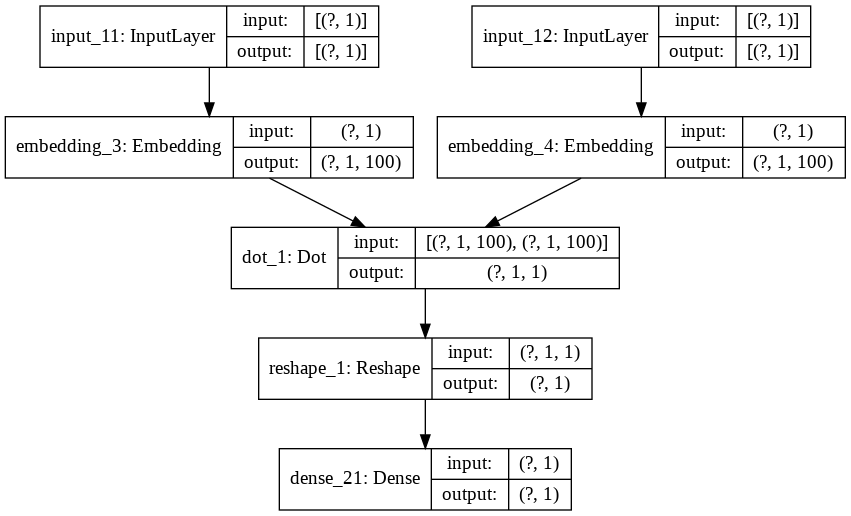

In [101]:
keras.utils.plot_model(model, show_shapes=True)

# index를 인풋으로 두개 받고,
# 그 인덱스를 embedding에 통과시킴으로서 one-hot * W를 곱한것과 같은 효과를 내주고
# W_target * W_context 를 dot 해줌으로써 유사도를 구하고
# 그놈을 true y값과 가까워 지도록 학습
# keras의 skipgram은 "타겟 임베딩과 컨텍스트 임베딩이 있는데, 그 둘의 유사도가 true 0,1값을 보고 그에 맞도록 임베딩의 가중치를 학습"

In [104]:
model.fit([word_target, word_context], labels, epochs=200)

Train on 1212 samples
Epoch 1/200
1212/1212 [==============================] - 0s 53us/sample - loss: 0.6925
Epoch 2/200
1212/1212 [==============================] - 0s 50us/sample - loss: 0.6924
Epoch 3/200
1212/1212 [==============================] - 0s 52us/sample - loss: 0.6924
Epoch 4/200
1212/1212 [==============================] - 0s 48us/sample - loss: 0.6924
Epoch 5/200
1212/1212 [==============================] - 0s 43us/sample - loss: 0.6924
Epoch 6/200
1212/1212 [==============================] - 0s 48us/sample - loss: 0.6923
Epoch 7/200
1212/1212 [==============================] - 0s 50us/sample - loss: 0.6923
Epoch 8/200
1212/1212 [==============================] - 0s 57us/sample - loss: 0.6923
Epoch 9/200
1212/1212 [==============================] - 0s 50us/sample - loss: 0.6923
Epoch 10/200
1212/1212 [==============================] - 0s 48us/sample - loss: 0.6922
Epoch 11/200
1212/1212 [==============================] - 0s 53us/sample - loss: 0.6922
Epoch 12/200
1212/1

### visualize

In [0]:
w = model.get_weights()

In [138]:
w[0].shape

(88581, 100)

In [139]:
w[1].shape

(88581, 100)

In [0]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(w[0])
PCA(n_components=2)
W_2 = pca.fit_transform(w[0])

In [0]:
word_list = []
for i in range(50):
  word_list.append(sorted(word_to_index.items(), key=lambda x: x[1])[i][0])

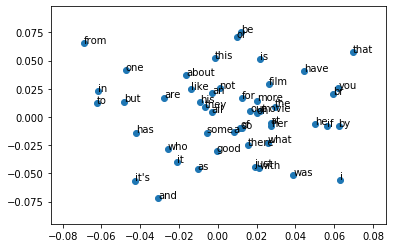

In [155]:
x = W_2[:50,0]
y = W_2[:50,1]
n = word_list

fig, ax = plt.subplots()
ax.scatter(x, y)

for i, txt in enumerate(n):
    ax.annotate(txt, (x[i], y[i]))